Sensitivity(x,y)=Score 
original
​
 −Score 
occluded
​
 (x,y)

c:\Users\birth\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\birth\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


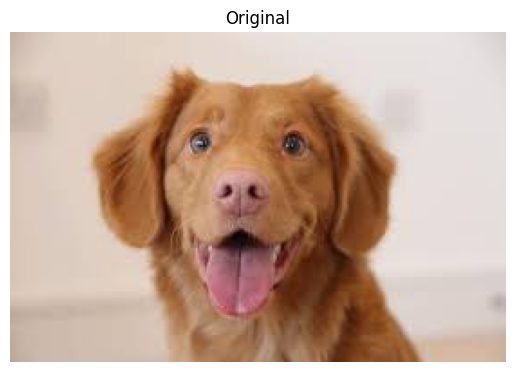

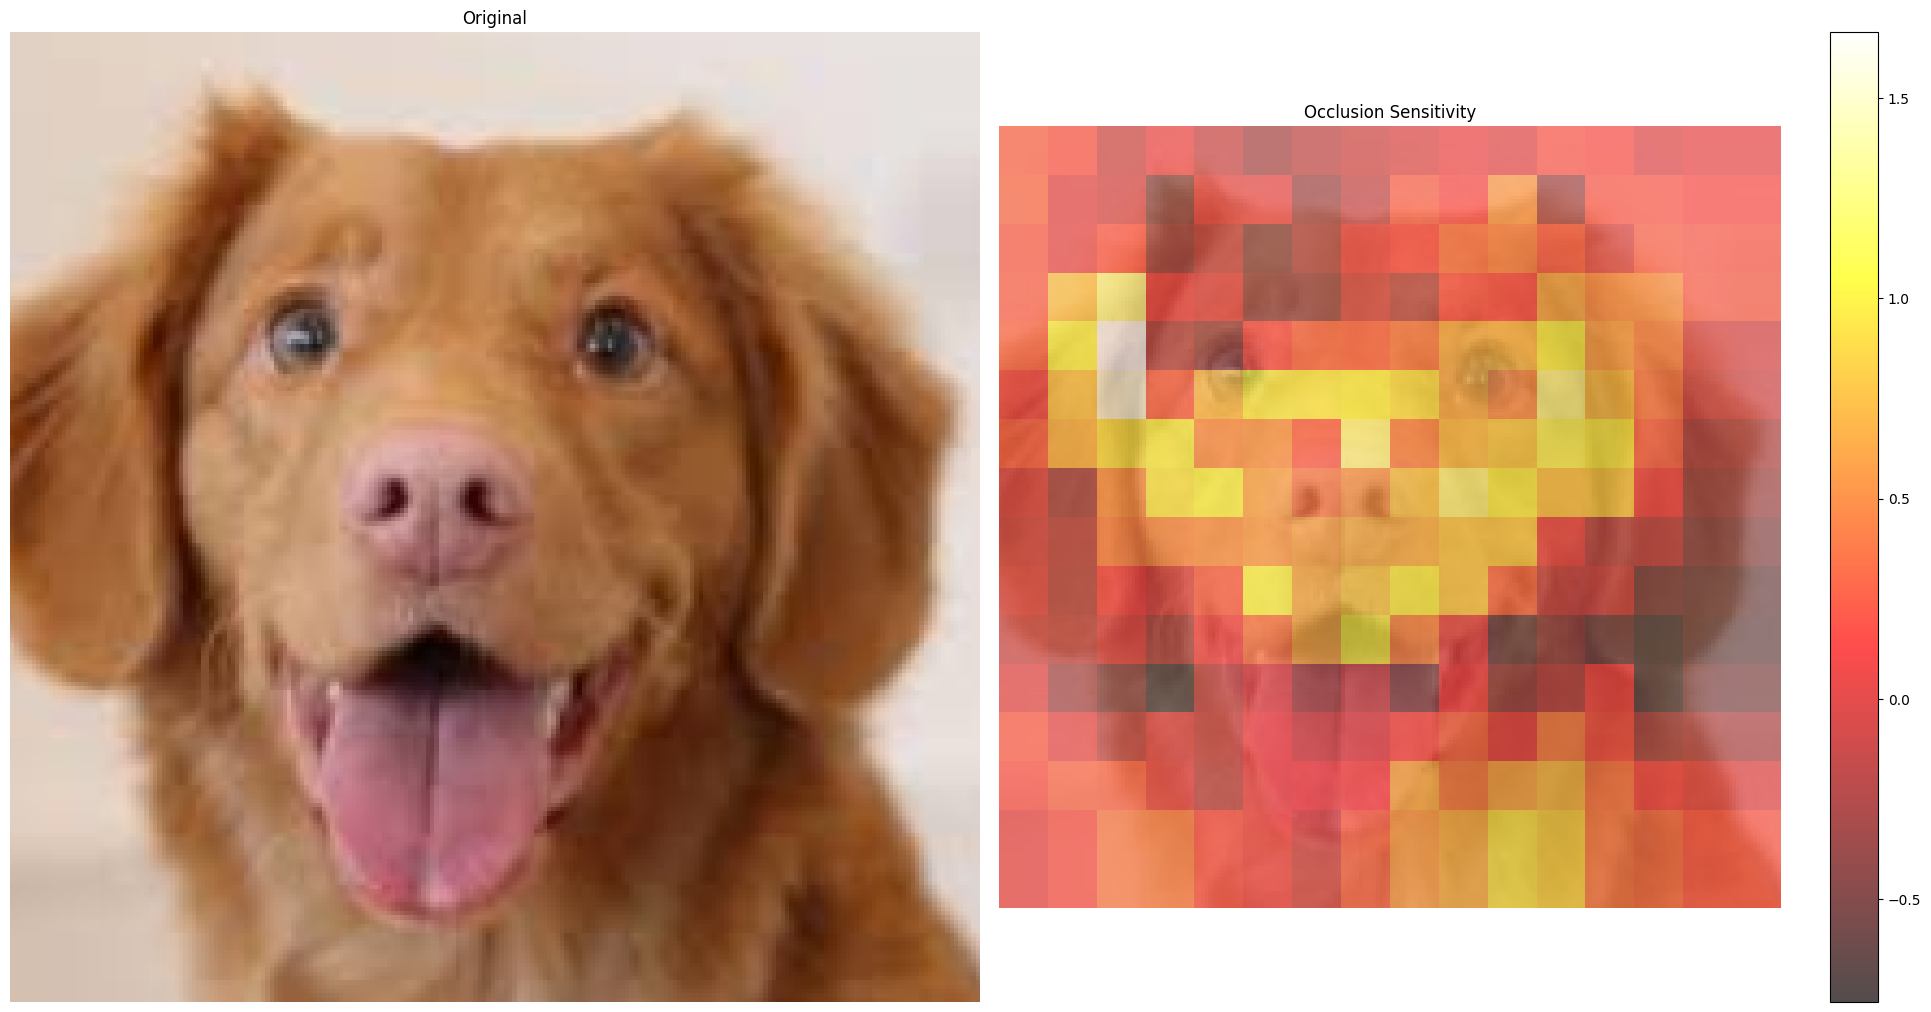

c:\Users\birth\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


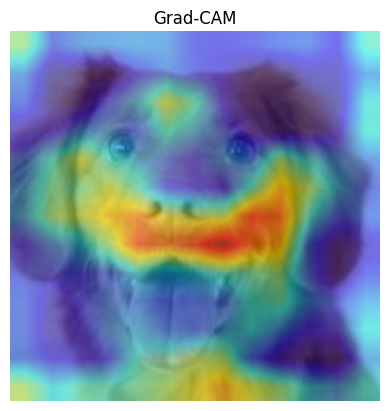

In [12]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# AlexNet 모델 불러오기 (pretrained=True로 사전 학습된 가중치 사용)
model = models.alexnet(pretrained=True)
model.eval()  # 모델을 평가 모드로 전환

# 이미지 전처리 파이프라인 정의
preprocess = transforms.Compose(
    [
        transforms.Resize(256),  # 이미지 크기를 256으로 조정
        transforms.CenterCrop(224),  # 중앙을 기준으로 224x224 크기로 잘라냄
        transforms.ToTensor(),  # 이미지를 Tensor로 변환
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]  # 평균으로 정규화
        ),  # 표준편차로 정규화
    ]
)


# 정규화를 되돌리는 함수 정의
def deprocess(image):
    """
    정규화된 텐서를 원래 이미지로 되돌립니다.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image * std + mean


# 옥클루전 민감도 분석 함수
def improved_occlusion_sensitivity(
    model, img_tensor, class_idx, patch_size=28, stride=14
):
    """
    옥클루전 민감도 분석을 수행하여 특정 클래스에 대한 예측 점수 변화를 시각화합니다.
    """
    # 원본 이미지에 대한 예측 점수
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0))
        orig_score = output[0, class_idx].item()

    # 옥클루전 결과를 저장할 배열 초기화
    sensitivity_map = np.zeros((224, 224))

    # 이미지 전체를 패치 단위로 옥클루션
    for x in range(0, 224 - patch_size + 1, stride):
        for y in range(0, 224 - patch_size + 1, stride):
            occluded = img_tensor.clone()
            # 패치 영역을 0으로 설정 (옥클루전)
            occluded[:, x : x + patch_size, y : y + patch_size] = 0
            with torch.no_grad():
                output = model(occluded.unsqueeze(0))
                occluded_score = output[0, class_idx].item()
            # 원본 점수와의 차이를 민감도로 사용
            sensitivity_map[x : x + patch_size, y : y + patch_size] = (
                orig_score - occluded_score
            )

    # 민감도 맵 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # 원본 이미지 표시
    ax1.imshow(deprocess(img_tensor).permute(1, 2, 0).numpy())
    ax1.set_title("Original")
    ax1.axis("off")

    # 민감도 맵 표시
    im = ax2.imshow(sensitivity_map, cmap="hot", interpolation="nearest", alpha=0.7)
    ax2.imshow(deprocess(img_tensor).permute(1, 2, 0).numpy(), alpha=0.3)
    ax2.set_title("Occlusion Sensitivity")
    ax2.axis("off")

    plt.colorbar(im, ax=ax2)
    plt.tight_layout()
    plt.show()


# Grad-CAM 구현 함수
def grad_cam(model, img_tensor, class_idx):
    """
    Grad-CAM을 사용하여 특정 클래스에 대한 활성화 맵을 생성합니다.
    """
    model.eval()

    # AlexNet의 마지막 컨볼루션 레이어 찾기
    target_layer = None
    for module in reversed(model.features):
        if isinstance(module, torch.nn.Conv2d):
            target_layer = module
            break

    if target_layer is None:
        raise ValueError("모델에서 컨볼루션 레이어를 찾을 수 없습니다.")

    # 활성화와 그래디언트를 저장할 변수 초기화
    activations = []
    gradients = []

    # 순전파 후킹 함수
    def forward_hook(module, input, output):
        activations.append(output)

    # 역전파 후킹 함수
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # 후킹 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 순전파 수행
    output = model(img_tensor.unsqueeze(0))

    # 타겟 클래스에 대한 원-핫 인코딩
    one_hot = torch.zeros_like(output)
    one_hot[0, class_idx] = 1

    # 역전파 수행
    model.zero_grad()
    output.backward(gradient=one_hot)

    # 후킹 제거
    forward_handle.remove()
    backward_handle.remove()

    # 활성화와 그래디언트 가져오기
    activation = activations[0].squeeze()  # [C, H, W]
    gradient = gradients[0].squeeze()  # [C, H, W]

    # 각 채널별 그래디언트의 평균을 가중치로 사용
    weights = torch.mean(gradient, dim=(1, 2))  # [C]

    # 가중치를 활성화에 곱하고 채널을 합침
    cam = torch.zeros(activation.shape[1:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * activation[i, :, :]

    # ReLU 적용하여 음수 값 제거
    cam = torch.nn.functional.relu(cam)

    # CAM을 0~1 범위로 정규화
    cam = cam - cam.min()
    cam = cam / cam.max()

    # NumPy 배열로 변환 (detach() 추가)
    cam = cam.detach().cpu().numpy()

    # CAM을 원본 이미지 크기로 리사이즈
    cam = cv2.resize(cam, (224, 224))

    return cam


# Grad-CAM 시각화 함수
def visualize_grad_cam(original_img, cam, alpha=0.5):
    """
    Grad-CAM 히트맵을 원본 이미지에 합성하여 시각화합니다.
    """
    # 원본 이미지 정규화 되돌리기 및 uint8 타입으로 변환
    original_img = deprocess(original_img).permute(1, 2, 0).numpy()
    original_img = np.uint8(original_img * 255)

    # CAM을 히트맵으로 변환 (0~255)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 히트맵과 원본 이미지를 합성
    superimposed_img = heatmap * alpha + original_img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img


# 메인 실행 코드
if __name__ == "__main__":
    # 이미지 경로 설정 (이미지 경로를 실제 이미지 파일 경로로 변경하세요)
    img_path = "puppy.jpg"

    # 이미지 열기 및 RGB 변환
    img = Image.open(img_path).convert("RGB")
    img_tensor = preprocess(img)

    # 원본 이미지 표시
    plt.imshow(np.array(img))
    plt.title("Original")
    plt.axis("off")
    plt.show()

    # 옥클루전 민감도 분석
    # class_idx=208은 ImageNet에서 'Labrador retriever' 클래스 인덱스입니다. 필요에 따라 변경하세요.
    improved_occlusion_sensitivity(model, img_tensor, class_idx=208)

    # Grad-CAM
    cam = grad_cam(model, img_tensor, class_idx=208)

    # Grad-CAM 시각화
    original_img = img_tensor
    grad_cam_img = visualize_grad_cam(original_img, cam, alpha=0.5)

    # Grad-CAM 결과 표시
    plt.imshow(grad_cam_img)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()